# count charging stations


# count charging stations


In [31]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point

In [32]:
# Ev charges stations in All the SA2 areas in victoria
ev_charges = pd.read_csv('/content/drive/MyDrive/data/ev_charging_victoria (6).csv')

In [33]:
# remove all the duplicate location in the ev_charges data set
df_cleaned = ev_charges.drop_duplicates(subset='address', keep='first')

In [34]:
# after that I could get 827 charing stations in each SA2 areas
df_cleaned.shape

(827, 5)

In [35]:
# Convert to GeoDataFrame
df_cleaned['geometry'] = df_cleaned.apply(lambda row: Point(row['longitude'], row['latitude']), axis=1)

/tmp/ipython-input-3669956329.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['geometry'] = df_cleaned.apply(lambda row: Point(row['longitude'], row['latitude']), axis=1)


In [36]:
df_cleaned.head()

,name,address,latitude,longitude,score,geometry
0,ChargeHub,"65 Eleanor Drive, Lucas, VIC, 3350",-37.544906,143.776381,1.213517,POINT (143.776381 -37.544906)
1,Tesla Supercharger,"6 Coltman Plaza, Lucas, VIC, 3350",-37.542959,143.784769,1.212916,POINT (143.784769 -37.542959)
2,Exploren,"265-285 Learmonth Road, Ballarat, VIC, 3355",-37.526716,143.809785,1.209702,POINT (143.809785 -37.526716)
3,Tesla Supercharger,"333 Gillies Street North, Ballarat, VIC, 3355",-37.534594,143.822667,1.208037,POINT (143.822667 -37.534594)
4,ChargeFox,"Gillies St N, Ballarat, VIC, 3355",-37.535163,143.823717,1.207874,POINT (143.823717 -37.535163)


In [37]:
df_cleaned.to_csv('df_cleaned_new.csv', index=False)

In [38]:
gdf_chargers = gpd.GeoDataFrame(df_cleaned, geometry='geometry', crs='EPSG:4326')

In [39]:
# 2. Load SA2 shapefile (Victoria only)
# Download from ABS site, unzip, and load .shp file
gdf_vic_sa2 = gpd.read_file("/content/drive/MyDrive/data/gdf_vic_copy.csv")

In [40]:
gdf_vic_sa2.head()

,SA2_CODE21,SA2_NAME21,geometry,ERP at 30 June 2023,ERP at 30 June 2023.1,ERP change 2023-24,%,Natural increase,Net internal migration,Net overseas migration,Area,Population density 2024(persons/km2),Total Population,Usual Resident Population,IRSAD Score,IRSAD Rank,IRSAD Decile,IRSAD Percentile
0,201011001,Alfredton,POLYGON ((143.78282104711133 -37.5666578080732...,18995.0,20130.0,1135.0,6.0,171.0,851.0,113.0,52.7,381.9,20126.13,16835.0,1011.0,1315.0,6.0,56.0
1,201011002,Ballarat,POLYGON ((143.81896375194268 -37.5558184903035...,11811.0,11773.0,-38.0,-0.3,-43.0,-103.0,108.0,12.4,951.1,11793.640000000001,12131.0,1040.0,1582.0,7.0,68.0
2,201011005,Buninyong,POLYGON ((143.8417079819547 -37.61596158212406...,7323.0,7358.0,35.0,0.5,13.0,-46.0,68.0,51.6,951.1,49076.76,7261.0,1040.0,1587.0,7.0,68.0
3,201011006,Delacombe,POLYGON ((143.7505006002539 -37.59119089617515...,12865.0,14271.0,1406.0,10.9,175.0,1198.0,33.0,34.2,417.8,14288.760000000002,10661.0,947.0,671.0,3.0,29.0
4,201011007,Smythes Creek,POLYGON ((143.7329551500814 -37.62333175526272...,4267.0,4278.0,11.0,0.3,22.0,-14.0,3.0,104.7,40.8,4271.76,4230.0,1005.0,1260.0,6.0,54.0


In [41]:
gdf_vic_sa2.shape

(522, 18)

In [42]:
from shapely import wkt
# Step 2: Convert the WKT geometry column to shapely geometries
gdf_vic_sa2['geometry'] = gdf_vic_sa2['geometry'].apply(wkt.loads)


The key is the use of shapely.wkt.loads to parse the POLYGON string into a geometry object.

You must know or define the correct CRS for your data; EPSG:4326 (latitude/longitude) is common.

Alternatively, if your CSV columns specify separate coordinate columns (e.g., for points), you could use gpd.points_from_xy() but for POLYGON WKT strings, the above method is standard.

In [43]:
# Step 3: Convert to GeoDataFrame, specify CRS if known (e.g. EPSG:4326)
gdf_vic_sa2 = gpd.GeoDataFrame(gdf_vic_sa2, geometry='geometry', crs='EPSG:4326')

<Axes: >

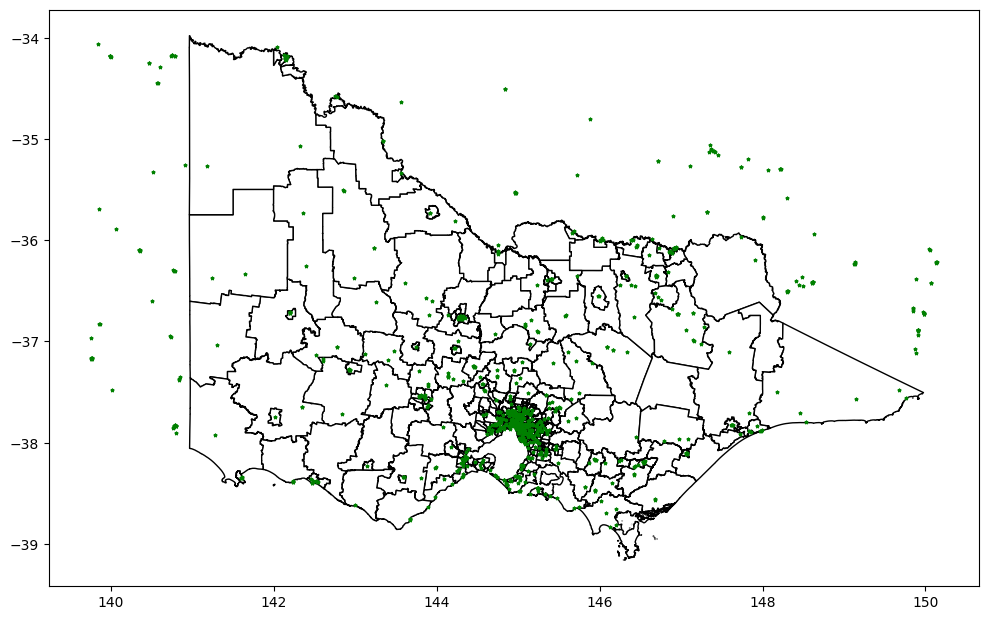

In [44]:
base = gdf_vic_sa2.plot(figsize=(12, 12), color='white', edgecolor='black')
gdf_chargers.plot(figsize=(12, 12), ax=base, marker='*', color='green', markersize=5)

In [45]:
print(gdf_chargers.crs)
print(gdf_vic_sa2.crs)

EPSG:4326
EPSG:4326


In [46]:
# 4. Spatial Join: Assign each charger to an SA2 region
chargers_in_sa2 = gpd.sjoin(gdf_vic_sa2, gdf_chargers, how='left', predicate='contains')

In [47]:
chargers_in_sa2.isnull().sum()

,0
SA2_CODE21,0
SA2_NAME21,0
geometry,0
ERP at 30 June 2023,0
ERP at 30 June 2023.1,0
ERP change 2023-24,0
%,0
Natural increase,0
Net internal migration,0
Net overseas migration,0


In [48]:
chargers_in_sa2['SA2_NAME21'].value_counts()

,count
SA2_NAME21,
Bright - Mount Beauty,12
Point Nepean,9
Melbourne CBD - East,8
Warrnambool - South,7
Phillip Island,7
...,...
Golden Plains - North,1
Beaufort,1
Gordon (Vic.),1


<Axes: >

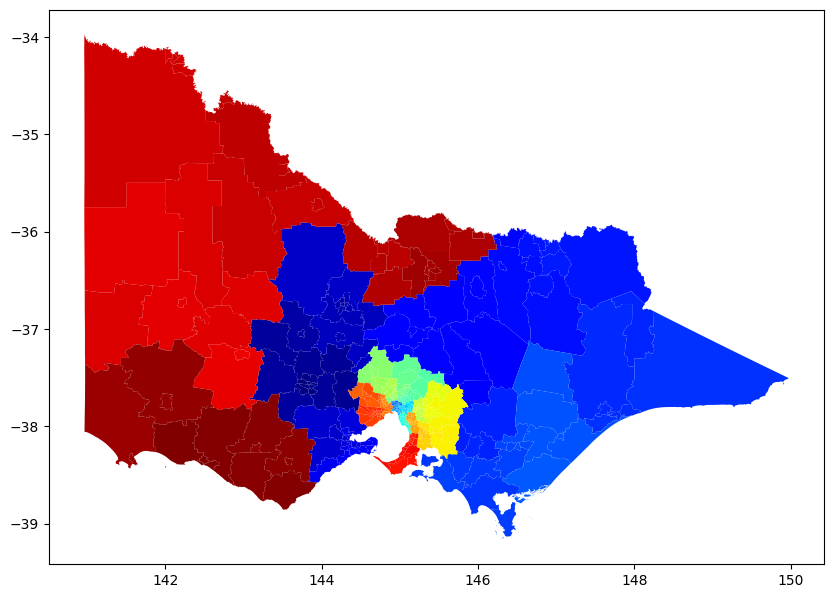

In [49]:
gdf_vic_sa2.plot(figsize=(10, 10), cmap = 'jet')

In [50]:
#Set the index according the SA2 name
gdf_vic_sa2.set_index('SA2_NAME21', inplace=True)
gdf_vic_sa2.head()

,SA2_CODE21,geometry,ERP at 30 June 2023,ERP at 30 June 2023.1,ERP change 2023-24,%,Natural increase,Net internal migration,Net overseas migration,Area,Population density 2024(persons/km2),Total Population,Usual Resident Population,IRSAD Score,IRSAD Rank,IRSAD Decile,IRSAD Percentile
SA2_NAME21,,,,,,,,,,,,,,,,,
Alfredton,201011001,"POLYGON ((143.78282 -37.56666, 143.75558 -37.5...",18995.0,20130.0,1135.0,6.0,171.0,851.0,113.0,52.7,381.9,20126.13,16835.0,1011.0,1315.0,6.0,56.0
Ballarat,201011002,"POLYGON ((143.81896 -37.55582, 143.81644 -37.5...",11811.0,11773.0,-38.0,-0.3,-43.0,-103.0,108.0,12.4,951.1,11793.640000000001,12131.0,1040.0,1582.0,7.0,68.0
Buninyong,201011005,"POLYGON ((143.84171 -37.61596, 143.84176 -37.6...",7323.0,7358.0,35.0,0.5,13.0,-46.0,68.0,51.6,951.1,49076.76,7261.0,1040.0,1587.0,7.0,68.0
Delacombe,201011006,"POLYGON ((143.7505 -37.59119, 143.75044 -37.59...",12865.0,14271.0,1406.0,10.9,175.0,1198.0,33.0,34.2,417.8,14288.760000000002,10661.0,947.0,671.0,3.0,29.0
Smythes Creek,201011007,"POLYGON ((143.73296 -37.62333, 143.73263 -37.6...",4267.0,4278.0,11.0,0.3,22.0,-14.0,3.0,104.7,40.8,4271.76,4230.0,1005.0,1260.0,6.0,54.0


In [51]:
gdf_vic_sa2['Charging_stations_count'] = chargers_in_sa2['SA2_NAME21'].value_counts()

In [52]:
gdf_vic_sa2.columns

Index(['SA2_CODE21', 'geometry', 'ERP at 30 June 2023',
       'ERP at 30 June 2023.1', 'ERP change 2023-24', '%', 'Natural increase',
       'Net internal migration', 'Net overseas migration', 'Area',
       'Population density 2024(persons/km2)', 'Total Population',
       'Usual Resident Population', 'IRSAD Score', 'IRSAD Rank',
       'IRSAD Decile', 'IRSAD Percentile', 'Charging_stations_count'],
      dtype='object')

In [53]:
gdf_vic_sa2.head()

,SA2_CODE21,geometry,ERP at 30 June 2023,ERP at 30 June 2023.1,ERP change 2023-24,%,Natural increase,Net internal migration,Net overseas migration,Area,Population density 2024(persons/km2),Total Population,Usual Resident Population,IRSAD Score,IRSAD Rank,IRSAD Decile,IRSAD Percentile,Charging_stations_count
SA2_NAME21,,,,,,,,,,,,,,,,,,
Alfredton,201011001,"POLYGON ((143.78282 -37.56666, 143.75558 -37.5...",18995.0,20130.0,1135.0,6.0,171.0,851.0,113.0,52.7,381.9,20126.13,16835.0,1011.0,1315.0,6.0,56.0,2
Ballarat,201011002,"POLYGON ((143.81896 -37.55582, 143.81644 -37.5...",11811.0,11773.0,-38.0,-0.3,-43.0,-103.0,108.0,12.4,951.1,11793.640000000001,12131.0,1040.0,1582.0,7.0,68.0,3
Buninyong,201011005,"POLYGON ((143.84171 -37.61596, 143.84176 -37.6...",7323.0,7358.0,35.0,0.5,13.0,-46.0,68.0,51.6,951.1,49076.76,7261.0,1040.0,1587.0,7.0,68.0,2
Delacombe,201011006,"POLYGON ((143.7505 -37.59119, 143.75044 -37.59...",12865.0,14271.0,1406.0,10.9,175.0,1198.0,33.0,34.2,417.8,14288.760000000002,10661.0,947.0,671.0,3.0,29.0,1
Smythes Creek,201011007,"POLYGON ((143.73296 -37.62333, 143.73263 -37.6...",4267.0,4278.0,11.0,0.3,22.0,-14.0,3.0,104.7,40.8,4271.76,4230.0,1005.0,1260.0,6.0,54.0,1


<Axes: >

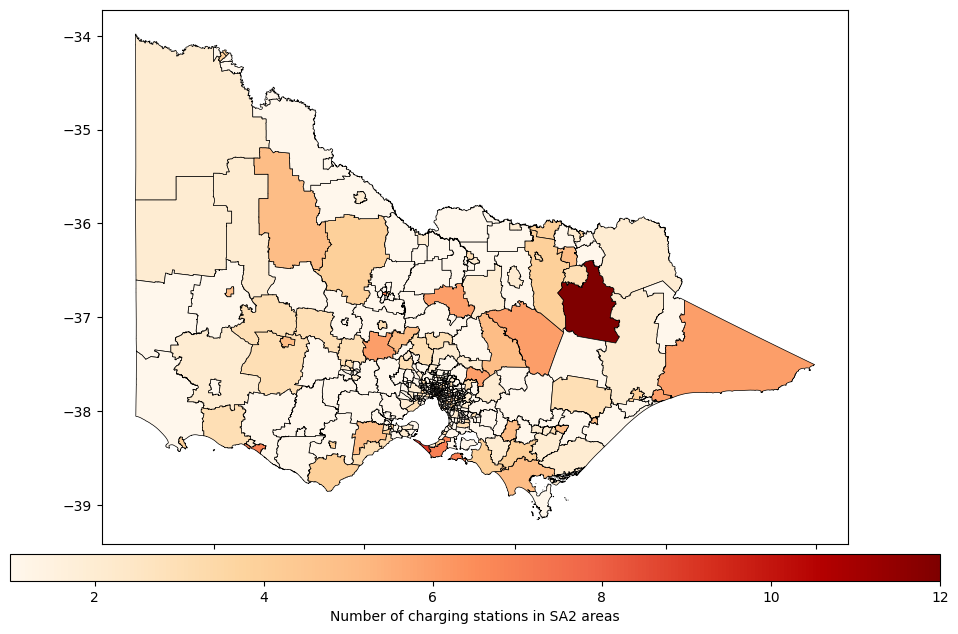

In [54]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
divider = make_axes_locatable(ax)
cax = divider.append_axes("bottom", size="5%", pad=0.1)
# plot the geographical data according to number of charging stations
gdf_vic_sa2.plot(
    column = 'Charging_stations_count',
    figsize=(12, 12),
    cmap = 'OrRd',
    ax=ax,
    legend=True,
    cax=cax,
    missing_kwds={
        "color": "lightgrey",
        "edgecolor": "red",
        "hatch": "///",
        "label": "Missing values",
    },
    legend_kwds={"label": "Number of charging stations in SA2 areas", "orientation": "horizontal"},
    edgecolor='black',
    linewidth=0.5,
    )

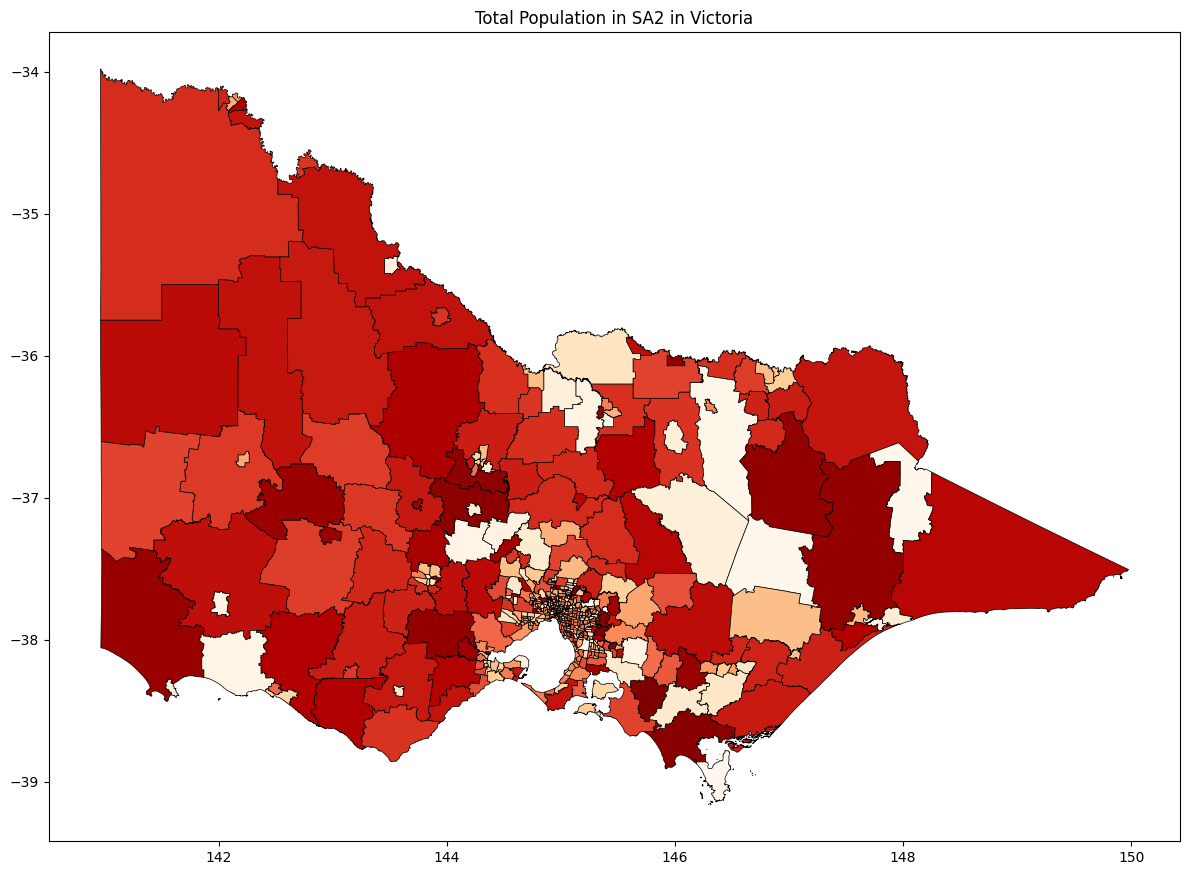

In [55]:
# plot the geographical data according to number of charging stations
gdf_vic_sa2.plot(
    column = 'Total Population',
    figsize=(12, 12),
    cmap='OrRd',
    edgecolor='black',
    linewidth=0.5,

    )
plt.title("Total Population in SA2 in Victoria")
plt.tight_layout()
plt.show()

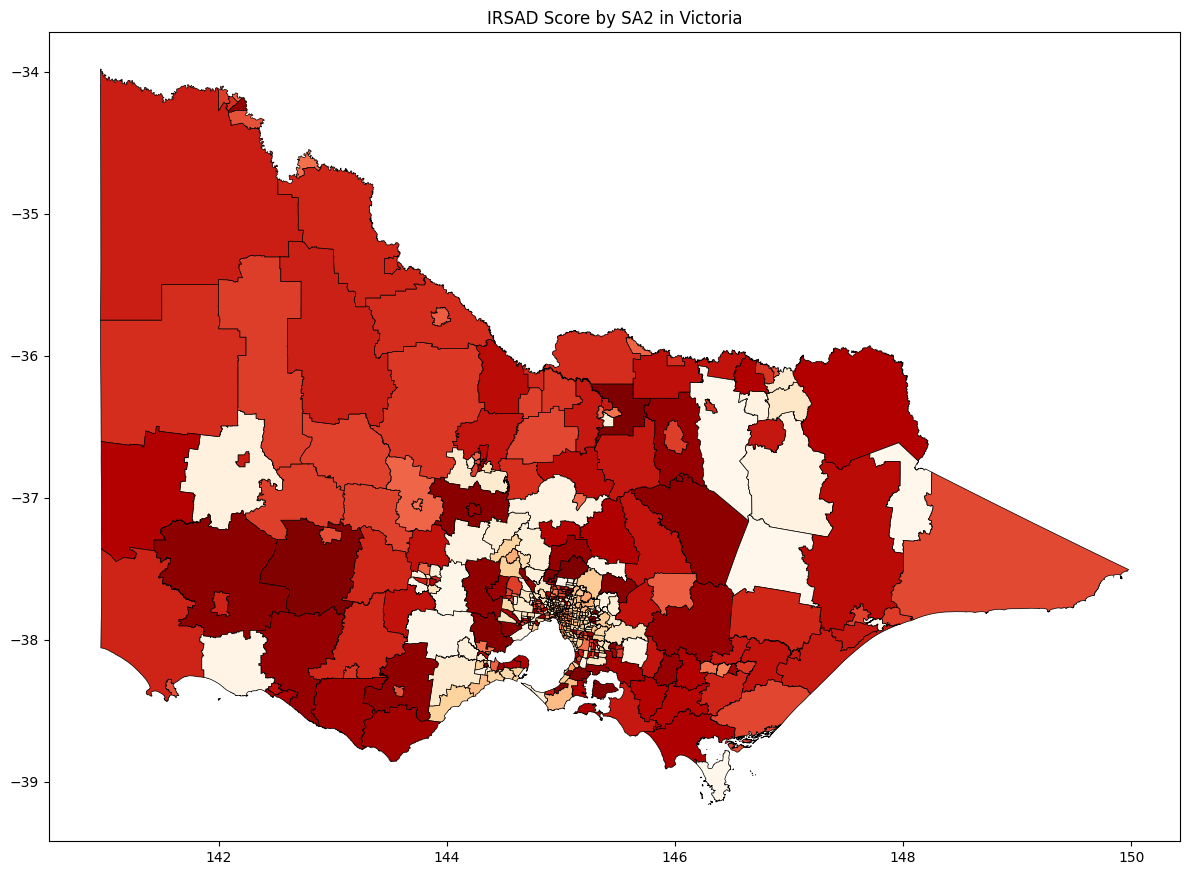

In [56]:
gdf_vic_sa2.plot(
    column = 'IRSAD Score',
    figsize=(12, 12),
    cmap = 'OrRd',
    edgecolor='black',
    linewidth=0.5,
    )
plt.title("IRSAD Score by SA2 in Victoria")
plt.tight_layout()
plt.show()

In [57]:
#gdf_vic_sa2.reset_index(inplace=True)
#gdf_vic_sa2.head()

In [58]:
gdf_vic_sa2.shape

(522, 18)